In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class InnovationOutlierDetector:
    """
    Advanced system for detecting innovation outliers in patent data.
    Identifies radical innovations, strategic pivots, and hidden gems through
    multi-dimensional anomaly detection combining textual, temporal, and metadata features.
    """

    def __init__(self, data_path=None, data=None):
        """
        Initialize the outlier detector.

        Args:
            data_path (str): Path to JSON file containing patent data
            data (list): Direct patent data as list of dictionaries
        """
        self.data_path = data_path
        self.raw_data = data
        self.df = None
        self.feature_vectors = None
        self.outlier_scores = {}
        self.models = {}
        self.scalers = {}
        self.analysis_results = {}

    def load_and_preprocess_data(self):
        """Load and preprocess patent data for outlier detection."""
        if self.raw_data is None:
            with open(self.data_path, 'r', encoding='utf-8') as f:
                self.raw_data = json.load(f)

        # Convert to DataFrame
        self.df = pd.DataFrame(self.raw_data)

        # Clean and preprocess dates
        self.df['date_published'] = pd.to_datetime(self.df['date_published'], errors='coerce')
        self.df['earliest_claim_date'] = pd.to_datetime(self.df['earliest_claim_date'], errors='coerce')

        # Calculate patent age and time gaps
        current_date = datetime.now()
        self.df['patent_age_days'] = (current_date - self.df['date_published']).dt.days
        self.df['claim_to_pub_gap'] = (self.df['date_published'] - self.df['earliest_claim_date']).dt.days

        # Handle missing values
        self.df['abstract_text'] = self.df['abstract_text'].fillna('')
        self.df['claims'] = self.df['claims'].fillna('')
        self.df['description'] = self.df['description'].fillna('')

        print(f"Loaded {len(self.df)} patents for outlier analysis")

    def extract_textual_features(self):
        """Extract advanced textual features for novelty detection."""
        features = {}

        # 1. Textual Uniqueness Features
        print("Extracting textual uniqueness features...")

        # TF-IDF for different text fields
        tfidf_abstract = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
        tfidf_claims = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))

        abstract_vectors = tfidf_abstract.fit_transform(self.df['abstract_text'])

        # Fix: Convert claims list to string properly
        claims_text = self.df['claims'].apply(
            lambda x: ' '.join(x) if isinstance(x, list) else str(x) if x is not None else ''
        )
        claims_vectors = tfidf_claims.fit_transform(claims_text)

        # Calculate uniqueness scores based on cosine similarity
        features['abstract_uniqueness'] = self._calculate_uniqueness_scores(abstract_vectors)
        features['claims_uniqueness'] = self._calculate_uniqueness_scores(claims_vectors)

        # 2. Language Complexity Features
        features['abstract_length'] = self.df['abstract_text'].str.len()

        # Fix: Handle claims list properly for length calculation
        features['claims_length'] = claims_text.str.len()
        features['description_length'] = self.df['description'].str.len()

        # Technical term density
        technical_terms = ['algorithm', 'neural', 'machine learning', 'artificial intelligence',
                          'deep learning', 'computer vision', 'sensor fusion', 'lidar', 'radar',
                          'autonomous', 'automated', 'self-driving', 'perception', 'localization']

        features['technical_density'] = self.df['abstract_text'].apply(
            lambda x: sum(term in str(x).lower() for term in technical_terms) / max(len(str(x).split()), 1)
        )

        # 3. Novelty Language Indicators
        novelty_indicators = ['novel', 'innovative', 'breakthrough', 'revolutionary', 'unprecedented',
                            'first', 'unique', 'advanced', 'improved', 'enhanced', 'optimized']

        features['novelty_language_score'] = self.df['abstract_text'].apply(
            lambda x: sum(term in str(x).lower() for term in novelty_indicators) / max(len(str(x).split()), 1)
        )

        return features

    def extract_metadata_features(self):
        """Extract metadata-based outlier features."""
        features = {}

        print("Extracting metadata features...")

        # 1. Temporal Outliers
        features['patent_age_days'] = self.df['patent_age_days']
        features['claim_to_pub_gap'] = self.df['claim_to_pub_gap'].fillna(0)

        # Publication timing anomalies (patents published at unusual times)
        self.df['pub_year'] = self.df['date_published'].dt.year
        self.df['pub_month'] = self.df['date_published'].dt.month

        # Calculate z-scores for publication timing
        features['pub_timing_anomaly'] = np.abs(stats.zscore(self.df['pub_month'].fillna(6)))

        # 2. CPC Classification Rarity
        # Flatten CPC symbols and calculate rarity scores
        all_cpc = []
        for cpc_list in self.df['cpc_symbols']:
            if isinstance(cpc_list, list):
                all_cpc.extend(cpc_list)

        cpc_counts = pd.Series(all_cpc).value_counts()

        # Calculate rarity score for each patent
        features['cpc_rarity_score'] = self.df['cpc_symbols'].apply(
            lambda x: np.mean([1/cpc_counts.get(cpc, 1) for cpc in x if isinstance(x, list) and cpc in cpc_counts])
            if isinstance(x, list) else 0
        )

        # 3. Applicant Strategic Shift Detection
        # Group patents by applicant and analyze technology diversity
        applicant_tech_diversity = self.df.groupby('applicant_name')['primary_category'].nunique()
        features['applicant_diversity'] = self.df['applicant_name'].map(applicant_tech_diversity)

        # 4. Technology Area Concentration
        features['tech_area_count'] = self.df['av_technology_areas'].apply(
            lambda x: len(x) if isinstance(x, list) else 0
        )

        # Note: Removed confidence_score and confidence_anomaly as they're not useful for outlier detection
        # (LLM categorization confidence is uniform across patents)

        return features

    def extract_innovation_patterns(self):
        """Extract advanced innovation pattern features."""
        features = {}

        print("Extracting innovation pattern features...")

        # 1. Cross-Domain Innovation Detection
        # Patents that span multiple traditionally separate domains
        traditional_domains = {
            'hardware': ['sensor', 'camera', 'lidar', 'radar', 'hardware'],
            'software': ['algorithm', 'software', 'code', 'program'],
            'ai_ml': ['artificial intelligence', 'machine learning', 'neural', 'deep learning'],
            'communication': ['communication', 'v2x', 'network', 'connectivity'],
            'safety': ['safety', 'security', 'cybersecurity', 'protection']
        }

        domain_scores = {}
        for domain, keywords in traditional_domains.items():
            domain_scores[domain] = self.df['abstract_text'].apply(
                lambda x: sum(keyword in str(x).lower() for keyword in keywords)
            )

        # Calculate cross-domain innovation score
        domain_matrix = pd.DataFrame(domain_scores)
        features['cross_domain_score'] = (domain_matrix > 0).sum(axis=1)
        features['domain_diversity'] = domain_matrix.std(axis=1)

        # 2. Invention Intensity - Fix: Ensure proper numeric types
        description_length = self.df['description'].str.len().fillna(0)
        estimated_tokens = pd.to_numeric(self.df['estimated_tokens'], errors='coerce').fillna(1)

        features['invention_intensity'] = (
            description_length * features['cross_domain_score'] /
            (estimated_tokens + 1)
        )

        # 3. Problem-Solution Novelty Gap - Fix: Handle string length properly
        problem_complexity = self.df['problem_addressed'].str.len().fillna(0)
        solution_novelty = self.df['novelty_aspect'].str.len().fillna(0)
        features['novelty_gap'] = solution_novelty / (problem_complexity + 1)

        return features

    def _calculate_uniqueness_scores(self, vectors):
        """Calculate uniqueness scores based on cosine similarity."""
        # Calculate pairwise similarities
        similarities = cosine_similarity(vectors)

        # For each patent, calculate average similarity to all others
        # Lower similarity = higher uniqueness
        avg_similarities = similarities.mean(axis=1)
        uniqueness_scores = 1 - avg_similarities

        return uniqueness_scores

    def build_autoencoder_detector(self, feature_matrix, encoding_dim=32):
        """Build autoencoder for anomaly detection."""
        input_dim = feature_matrix.shape[1]

        # Encoder
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(128, activation='relu')(input_layer)
        encoded = Dropout(0.2)(encoded)
        encoded = Dense(64, activation='relu')(encoded)
        encoded = Dropout(0.2)(encoded)
        encoded = Dense(encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = Dense(64, activation='relu')(encoded)
        decoded = Dropout(0.2)(decoded)
        decoded = Dense(128, activation='relu')(decoded)
        decoded = Dropout(0.2)(decoded)
        decoded = Dense(input_dim, activation='linear')(decoded)

        # Autoencoder model
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        return autoencoder

    def detect_outliers(self):
        """Main method to detect innovation outliers using multiple techniques."""
        print("Starting comprehensive outlier detection...")

        # Extract all feature types
        textual_features = self.extract_textual_features()
        metadata_features = self.extract_metadata_features()
        pattern_features = self.extract_innovation_patterns()

        # Combine all features
        all_features = {**textual_features, **metadata_features, **pattern_features}
        feature_df = pd.DataFrame(all_features)

        # Handle missing values
        feature_df = feature_df.fillna(feature_df.median())

        # Standardize features
        scaler = StandardScaler()
        feature_matrix = scaler.fit_transform(feature_df)
        self.scalers['main'] = scaler

        # 1. Isolation Forest Detection
        print("Running Isolation Forest detection...")
        iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=200)
        iso_outliers = iso_forest.fit_predict(feature_matrix)
        iso_scores = iso_forest.decision_function(feature_matrix)

        self.outlier_scores['isolation_forest'] = {
            'predictions': iso_outliers,
            'scores': iso_scores
        }

        # 2. Autoencoder Detection
        print("Running Autoencoder detection...")
        autoencoder = self.build_autoencoder_detector(feature_matrix)
        autoencoder.fit(feature_matrix, feature_matrix,
                       epochs=50, batch_size=32, verbose=0, validation_split=0.2)

        # Calculate reconstruction errors
        reconstructed = autoencoder.predict(feature_matrix, verbose=0)
        reconstruction_errors = np.mean(np.square(feature_matrix - reconstructed), axis=1)

        # Determine autoencoder outliers (top 10% reconstruction errors)
        error_threshold = np.percentile(reconstruction_errors, 90)
        autoencoder_outliers = (reconstruction_errors > error_threshold).astype(int)
        autoencoder_outliers[autoencoder_outliers == 0] = -1  # Convert to -1/1 format

        self.outlier_scores['autoencoder'] = {
            'predictions': autoencoder_outliers,
            'scores': reconstruction_errors
        }

        # 3. DBSCAN Clustering for Outlier Detection
        print("Running DBSCAN clustering...")
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        cluster_labels = dbscan.fit_predict(feature_matrix)

        # Points labeled as -1 are outliers in DBSCAN
        dbscan_outliers = (cluster_labels == -1).astype(int)
        dbscan_outliers[dbscan_outliers == 0] = -1

        self.outlier_scores['dbscan'] = {
            'predictions': dbscan_outliers,
            'scores': cluster_labels
        }

        # 4. Statistical Outlier Detection (Multivariate)
        print("Running statistical outlier detection...")
        # Mahalanobis distance
        try:
            cov_matrix = np.cov(feature_matrix.T)
            inv_cov_matrix = np.linalg.inv(cov_matrix)
            mean_vec = np.mean(feature_matrix, axis=0)

            mahal_distances = []
            for row in feature_matrix:
                diff = row - mean_vec
                mahal_dist = np.sqrt(np.dot(np.dot(diff, inv_cov_matrix), diff))
                mahal_distances.append(mahal_dist)

            mahal_distances = np.array(mahal_distances)
            mahal_threshold = np.percentile(mahal_distances, 90)
            statistical_outliers = (mahal_distances > mahal_threshold).astype(int)
            statistical_outliers[statistical_outliers == 0] = -1

            self.outlier_scores['statistical'] = {
                'predictions': statistical_outliers,
                'scores': mahal_distances
            }
        except:
            print("Mahalanobis distance calculation failed, using z-score method")
            z_scores = np.abs(stats.zscore(feature_matrix, axis=0))
            max_z_scores = np.max(z_scores, axis=1)
            z_threshold = 2.5
            statistical_outliers = (max_z_scores > z_threshold).astype(int)
            statistical_outliers[statistical_outliers == 0] = -1

            self.outlier_scores['statistical'] = {
                'predictions': statistical_outliers,
                'scores': max_z_scores
            }

        # Store feature information
        self.feature_vectors = feature_matrix
        self.feature_names = list(feature_df.columns)

        print("Outlier detection completed!")

    def ensemble_outlier_scoring(self):
        """Combine multiple outlier detection methods for robust scoring."""
        print("Creating ensemble outlier scores...")

        # Normalize all scores to [0, 1] range
        normalized_scores = {}

        for method, results in self.outlier_scores.items():
            scores = results['scores']
            if method == 'dbscan':
                # For DBSCAN, convert cluster labels to outlier scores
                scores = (scores == -1).astype(float)
            else:
                # Normalize scores to [0, 1]
                scores = (scores - scores.min()) / (scores.max() - scores.min())

            normalized_scores[method] = scores

        # Create ensemble score (weighted average)
        weights = {
            'isolation_forest': 0.3,
            'autoencoder': 0.3,
            'statistical': 0.25,
            'dbscan': 0.15
        }

        ensemble_scores = np.zeros(len(self.df))
        for method, weight in weights.items():
            if method in normalized_scores:
                ensemble_scores += weight * normalized_scores[method]

        # Create final outlier predictions
        ensemble_threshold = np.percentile(ensemble_scores, 85)  # Top 15% as outliers
        ensemble_predictions = (ensemble_scores > ensemble_threshold).astype(int)

        self.outlier_scores['ensemble'] = {
            'predictions': ensemble_predictions,
            'scores': ensemble_scores
        }

        return ensemble_scores, ensemble_predictions

    def analyze_outlier_characteristics(self):
        """Analyze characteristics of detected outliers."""
        print("Analyzing outlier characteristics...")

        ensemble_scores, ensemble_predictions = self.ensemble_outlier_scoring()

        # Add outlier information to dataframe
        self.df['outlier_score'] = ensemble_scores
        self.df['is_outlier'] = ensemble_predictions

        # Separate outliers and normal patents
        outliers = self.df[self.df['is_outlier'] == 1].copy()
        normal = self.df[self.df['is_outlier'] == 0].copy()

        analysis = {}

        # 1. Outlier Statistics
        analysis['outlier_count'] = len(outliers)
        analysis['outlier_percentage'] = (len(outliers) / len(self.df)) * 100

        # 2. Applicant Analysis
        outlier_applicants = outliers['applicant_name'].value_counts().head(10)
        normal_applicants = normal['applicant_name'].value_counts().head(10)

        analysis['top_outlier_applicants'] = outlier_applicants.to_dict()
        analysis['applicant_outlier_rates'] = {}

        for applicant in outlier_applicants.index:
            total_patents = len(self.df[self.df['applicant_name'] == applicant])
            outlier_patents = len(outliers[outliers['applicant_name'] == applicant])
            analysis['applicant_outlier_rates'][applicant] = (outlier_patents / total_patents) * 100

        # 3. Technology Area Analysis
        outlier_tech_areas = []
        for areas in outliers['av_technology_areas']:
            if isinstance(areas, list):
                outlier_tech_areas.extend(areas)

        analysis['outlier_tech_distribution'] = pd.Series(outlier_tech_areas).value_counts().to_dict()

        # 4. Temporal Analysis
        outliers['pub_year'] = outliers['date_published'].dt.year
        analysis['outlier_temporal_distribution'] = outliers['pub_year'].value_counts().sort_index().to_dict()

        # 5. Novel Language Analysis - Fix: Handle string length properly
        analysis['avg_outlier_novelty_score'] = outliers['novelty_aspect'].str.len().mean()
        analysis['avg_normal_novelty_score'] = normal['novelty_aspect'].str.len().mean()

        self.analysis_results = analysis

        return analysis

    def identify_strategic_pivots(self):
        """Identify companies making strategic pivots based on outlier patterns."""
        print("Identifying strategic pivots...")

        pivots = {}

        # Group by applicant and analyze outlier patterns over time
        for applicant in self.df['applicant_name'].unique():
            applicant_data = self.df[self.df['applicant_name'] == applicant].copy()

            if len(applicant_data) < 5:  # Skip applicants with too few patents
                continue

            # Sort by date
            applicant_data = applicant_data.sort_values('date_published')

            # Calculate rolling outlier rate
            applicant_data['year'] = applicant_data['date_published'].dt.year
            yearly_outliers = applicant_data.groupby('year')['is_outlier'].agg(['count', 'sum'])
            yearly_outliers['outlier_rate'] = yearly_outliers['sum'] / yearly_outliers['count']

            # Detect significant increases in outlier rate
            if len(yearly_outliers) >= 3:
                outlier_rates = yearly_outliers['outlier_rate'].values
                rate_changes = np.diff(outlier_rates)

                # Look for sustained increases
                if np.any(rate_changes > 0.3):  # 30% increase in outlier rate
                    pivot_year = yearly_outliers.index[np.argmax(rate_changes) + 1]

                    pivots[applicant] = {
                        'pivot_year': pivot_year,
                        'outlier_rate_increase': np.max(rate_changes),
                        'total_patents': len(applicant_data),
                        'outlier_patents': applicant_data['is_outlier'].sum(),
                        'recent_tech_areas': applicant_data[applicant_data['year'] >= pivot_year]['primary_category'].value_counts().to_dict()
                    }

        return pivots

    def generate_insights_report(self):
        """Generate comprehensive insights report."""
        print("Generating insights report...")

        # Ensure analysis is complete
        if not self.outlier_scores:
            self.detect_outliers()

        analysis = self.analyze_outlier_characteristics()
        pivots = self.identify_strategic_pivots()

        # Get top outliers for detailed analysis
        top_outliers = self.df.nlargest(20, 'outlier_score')[
            ['lens_id', 'invention_title_text', 'applicant_name', 'date_published',
             'primary_category', 'outlier_score', 'novelty_aspect']
        ]

        report = {
            'summary': {
                'total_patents_analyzed': len(self.df),
                'outliers_detected': analysis['outlier_count'],
                'outlier_percentage': analysis['outlier_percentage'],
                'detection_methods_used': list(self.outlier_scores.keys())
            },
            'top_outlier_patents': top_outliers.to_dict('records'),
            'strategic_pivots': pivots,
            'outlier_characteristics': analysis,
            'key_insights': self._generate_key_insights(analysis, pivots, top_outliers)
        }

        return report

    def _generate_key_insights(self, analysis, pivots, top_outliers):
        """Generate key insights from the analysis."""
        insights = []

        # Innovation leaders
        if analysis['top_outlier_applicants']:
            top_innovator = list(analysis['top_outlier_applicants'].keys())[0]
            insights.append(f"Most innovative outlier producer: {top_innovator} with {analysis['top_outlier_applicants'][top_innovator]} radical innovations")

        # Emerging technologies
        if analysis['outlier_tech_distribution']:
            top_tech = max(analysis['outlier_tech_distribution'], key=analysis['outlier_tech_distribution'].get)
            insights.append(f"Technology area with most radical innovations: {top_tech}")

        # Strategic pivots
        if pivots:
            pivot_companies = list(pivots.keys())[:3]
            insights.append(f"Companies showing strategic pivots: {', '.join(pivot_companies)}")

        # Temporal patterns
        if analysis['outlier_temporal_distribution']:
            peak_year = max(analysis['outlier_temporal_distribution'], key=analysis['outlier_temporal_distribution'].get)
            insights.append(f"Peak year for radical innovations: {peak_year}")

        # Novelty patterns
        if 'avg_outlier_novelty_score' in analysis:
            novelty_ratio = analysis['avg_outlier_novelty_score'] / analysis['avg_normal_novelty_score']
            insights.append(f"Outlier patents have {novelty_ratio:.2f}x more detailed novelty descriptions")

        return insights

    def visualize_outliers(self, save_plots=True):
        """Create visualizations for outlier analysis."""
        plt.style.use('default')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Innovation Outlier Detection Analysis', fontsize=16, fontweight='bold')

        # 1. Outlier Score Distribution
        axes[0, 0].hist(self.df['outlier_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].axvline(self.df['outlier_score'].quantile(0.85), color='red', linestyle='--', label='Outlier Threshold')
        axes[0, 0].set_xlabel('Outlier Score')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Outlier Scores')
        axes[0, 0].legend()

        # 2. Top Outlier Applicants
        if self.analysis_results['top_outlier_applicants']:
            top_applicants = list(self.analysis_results['top_outlier_applicants'].items())[:8]
            companies, counts = zip(*top_applicants)
            axes[0, 1].barh(range(len(companies)), counts, color='lightcoral')
            axes[0, 1].set_yticks(range(len(companies)))
            axes[0, 1].set_yticklabels([c[:20] + '...' if len(c) > 20 else c for c in companies])
            axes[0, 1].set_xlabel('Number of Outlier Patents')
            axes[0, 1].set_title('Top Companies by Outlier Patents')

        # 3. Temporal Distribution
        if self.analysis_results['outlier_temporal_distribution']:
            years = list(self.analysis_results['outlier_temporal_distribution'].keys())
            counts = list(self.analysis_results['outlier_temporal_distribution'].values())
            axes[0, 2].plot(years, counts, marker='o', linewidth=2, markersize=6, color='green')
            axes[0, 2].set_xlabel('Year')
            axes[0, 2].set_ylabel('Number of Outliers')
            axes[0, 2].set_title('Outlier Patents Over Time')
            axes[0, 2].grid(True, alpha=0.3)

        # 4. Technology Area Distribution
        if self.analysis_results['outlier_tech_distribution']:
            tech_areas = list(self.analysis_results['outlier_tech_distribution'].items())[:8]
            areas, counts = zip(*tech_areas)
            axes[1, 0].pie(counts, labels=[a[:15] + '...' if len(a) > 15 else a for a in areas],
                          autopct='%1.1f%%', startangle=90)
            axes[1, 0].set_title('Outlier Distribution by Technology Area')

        # 5. Outlier Score vs Patent Age
        axes[1, 1].scatter(self.df['patent_age_days'], self.df['outlier_score'],
                          alpha=0.6, c=self.df['is_outlier'], cmap='RdYlBu')
        axes[1, 1].set_xlabel('Patent Age (Days)')
        axes[1, 1].set_ylabel('Outlier Score')
        axes[1, 1].set_title('Outlier Score vs Patent Age')

        # 6. Method Comparison
        methods = ['isolation_forest', 'autoencoder', 'statistical', 'dbscan']
        method_counts = []
        for method in methods:
            if method in self.outlier_scores:
                outlier_count = np.sum(self.outlier_scores[method]['predictions'] == 1)
                method_counts.append(outlier_count)
            else:
                method_counts.append(0)

        axes[1, 2].bar(methods, method_counts, color=['blue', 'orange', 'green', 'red'], alpha=0.7)
        axes[1, 2].set_xlabel('Detection Method')
        axes[1, 2].set_ylabel('Outliers Detected')
        axes[1, 2].set_title('Outliers by Detection Method')
        axes[1, 2].tick_params(axis='x', rotation=45)

        plt.tight_layout()

        if save_plots:
            plt.savefig('innovation_outlier_analysis.png', dpi=300, bbox_inches='tight')
            print("Plots saved as 'innovation_outlier_analysis.png'")

        plt.show()

        return fig

    def export_results(self, filename='innovation_outliers_results.json'):
        """Export analysis results to JSON file."""
        results = self.generate_insights_report()

        # Convert numpy types to Python types for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj

        # Deep convert all numpy types
        def deep_convert(obj):
            if isinstance(obj, dict):
                return {k: deep_convert(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [deep_convert(v) for v in obj]
            else:
                return convert_numpy(obj)

        results = deep_convert(results)

        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False, default=str)

        print(f"Results exported to {filename}")

        # Also export detailed outlier data
        outlier_data = self.df[self.df['is_outlier'] == 1][
            ['lens_id', 'invention_title_text', 'applicant_name', 'date_published',
             'primary_category', 'outlier_score', 'abstract_text', 'novelty_aspect']
        ].copy()

        outlier_filename = 'detailed_outlier_patents.csv'
        outlier_data.to_csv(outlier_filename, index=False)
        print(f"Detailed outlier patents exported to {outlier_filename}")

    def run_complete_analysis(self, visualize=True, export=True):
        """Run the complete innovation outlier detection pipeline."""
        print("="*60)
        print("INNOVATION OUTLIER DETECTION PIPELINE")
        print("="*60)

        # Step 1: Load and preprocess data
        self.load_and_preprocess_data()

        # Step 2: Detect outliers using multiple methods
        self.detect_outliers()

        # Step 3: Generate comprehensive analysis
        report = self.generate_insights_report()

        # Step 4: Print summary
        self._print_summary_report(report)

        # Step 5: Visualize results
        if visualize:
            self.visualize_outliers()

        # Step 6: Export results
        if export:
            self.export_results()

        print("="*60)
        print("ANALYSIS COMPLETE!")
        print("="*60)

        return report

    def _print_summary_report(self, report):
        """Print a formatted summary report."""
        print("\n" + "="*50)
        print("INNOVATION OUTLIER DETECTION SUMMARY")
        print("="*50)

        # Summary statistics
        summary = report['summary']
        print(f"\n ANALYSIS OVERVIEW:")
        print(f"   Total Patents Analyzed: {summary['total_patents_analyzed']:,}")
        print(f"   Outliers Detected: {summary['outliers_detected']:,}")
        print(f"   Outlier Percentage: {summary['outlier_percentage']:.2f}%")
        print(f"   Detection Methods: {', '.join(summary['detection_methods_used'])}")

        # Top outlier patents
        print(f"\n TOP 5 RADICAL INNOVATION PATENTS:")
        for i, patent in enumerate(report['top_outlier_patents'][:5], 1):
            print(f"   {i}. {patent['invention_title_text'][:60]}...")
            print(f"      Company: {patent['applicant_name']}")
            print(f"      Outlier Score: {patent['outlier_score']:.4f}")
            print(f"      Technology: {patent['primary_category']}")
            print()

        # Strategic pivots
        if report['strategic_pivots']:
            print(f" STRATEGIC PIVOTS DETECTED ({len(report['strategic_pivots'])} companies):")
            for company, pivot_info in list(report['strategic_pivots'].items())[:3]:
                print(f"   • {company}")
                print(f"     Pivot Year: {pivot_info['pivot_year']}")
                print(f"     Outlier Rate Increase: {pivot_info['outlier_rate_increase']:.1%}")
                print(f"     Recent Focus: {list(pivot_info['recent_tech_areas'].keys())[:2]}")
                print()

        # Key insights
        print(f" KEY INSIGHTS:")
        for insight in report['key_insights']:
            print(f"   • {insight}")

        # Innovation leaders
        outlier_chars = report['outlier_characteristics']
        if outlier_chars['top_outlier_applicants']:
            print(f"\n TOP INNOVATION LEADERS:")
            for company, count in list(outlier_chars['top_outlier_applicants'].items())[:5]:
                outlier_rate = outlier_chars['applicant_outlier_rates'].get(company, 0)
                print(f"   • {company}: {count} outlier patents ({outlier_rate:.1f}% rate)")

        print("\n" + "="*50)

INNOVATION OUTLIER DETECTION PIPELINE
Loaded 667 patents for outlier analysis
Starting comprehensive outlier detection...
Extracting textual uniqueness features...
Extracting metadata features...
Extracting innovation pattern features...
Running Isolation Forest detection...
Running Autoencoder detection...
Running DBSCAN clustering...
Running statistical outlier detection...
Outlier detection completed!
Generating insights report...
Analyzing outlier characteristics...
Creating ensemble outlier scores...
Identifying strategic pivots...

INNOVATION OUTLIER DETECTION SUMMARY

 ANALYSIS OVERVIEW:
   Total Patents Analyzed: 667
   Outliers Detected: 100
   Outlier Percentage: 14.99%
   Detection Methods: isolation_forest, autoencoder, dbscan, statistical, ensemble

 TOP 5 RADICAL INNOVATION PATENTS:
   1. Video compression using recurrent-based machine learning sys...
      Company: QUALCOMM INC
      Outlier Score: 0.7671
      Technology: Video Compression

   2. Dynamic uplink data spl

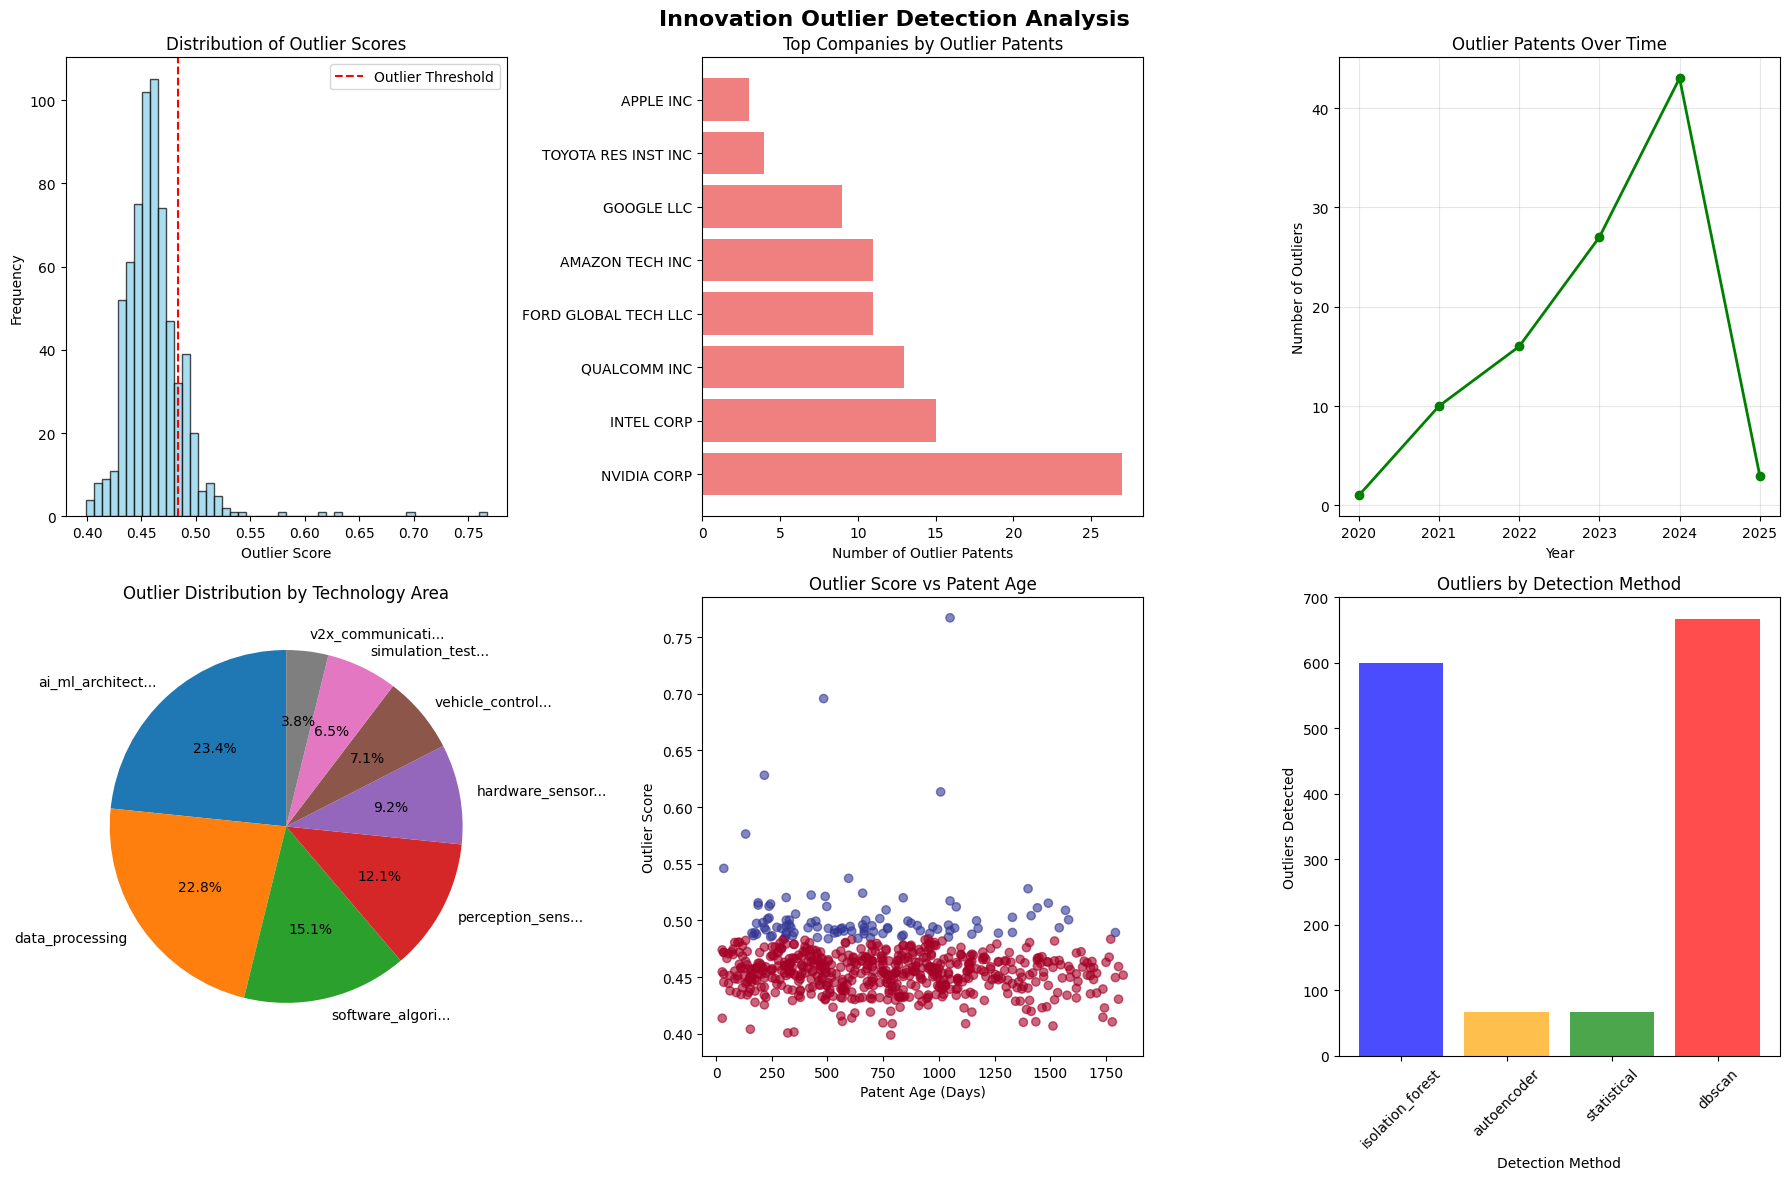

Generating insights report...
Analyzing outlier characteristics...
Creating ensemble outlier scores...
Identifying strategic pivots...
Results exported to innovation_outliers_results.json
Detailed outlier patents exported to detailed_outlier_patents.csv
ANALYSIS COMPLETE!


In [ ]:
# Example usage and demonstration
if __name__ == "__main__":
    # Uncomment below to run with your data:
    detector = InnovationOutlierDetector('/content/av_patent_data.json')
    results = detector.run_complete_analysis()